In [1]:
import pandas as pd
import numpy as np
import torch
import sys
import glob
import matplotlib.pyplot as plt
from collections import OrderedDict
import sklearn.metrics as sk_metrics

from flwr.common.typing import Parameters
from flwr.common import parameters_to_weights, weights_to_parameters

sys.path.append('../../')
from Metrics import Metrics
from MyUtils import get_tensor_loader, bool_attack, convert_bool, get_predictions
from Net import AnalysisNet
from Args import args
from ReinforcementUtils import array_softmax

In [2]:
def print_graphs(folder):
#     plt.close()
    metric_files = glob.glob('../../results/' + folder + '/**-metrics.npy')
    agents_metrics = []

    for file in metric_files:
        print(file)
        m = np.load(file, allow_pickle=True)
        agents_metrics.append(m.item())
    
    print('Number of agents: ' + str(len(agents_metrics)))
    print('Saving graphs for Accuracy...')
    for i in range(len(agents_metrics)):
        plt.plot(agents_metrics[i]['accuracy'])
        plt.xlabel('Number of training rounds')
        plt.ylabel('Accuracy')
        plt.title('Agent-' + str(i))
        plt.show()
        plt.savefig('../../results/Analysis/pics/' + folder + '/accuracy-agent-' + str(i) + '.png')
        plt.close()
    
    
    print('Saving graphs for Loss...')
    for i in range(len(agents_metrics)):
        plt.plot(agents_metrics[i]['loss'])
        plt.xlabel('Number of training rounds')
        plt.ylabel('Loss')
        plt.title('Agent-' + str(i))
        plt.show()
        plt.savefig('../../results/Analysis/pics/' + folder + '/loss-agent-' + str(i) + '.png')
        plt.close()
    
    print('Saving graphs for Attention values..')
    for i in range(len(agents_metrics)):
        plt.plot(agents_metrics[i]['attention_value'])
        plt.xlabel('Number of training rounds')
        plt.ylabel('Attention value')
        plt.title('Agent-' + str(i))
        plt.show()
        plt.savefig('../../results/Analysis/pics/' + folder + '/attention-values-agent-' + str(i) + '.png')
        plt.close()

In [3]:
def print_graphs_subplots(folder, nx, ny, title):
    metric_files = glob.glob('../../results/' + folder + '/**-metrics.npy')
    agents_metrics = []

    for file in metric_files:
        print(file)
        m = np.load(file, allow_pickle=True)
        agents_metrics.append(m.item())
    
    print('Number of agents: ' + str(len(agents_metrics)))
    print('Saving graphs for Accuracy...')
    acc_fig, acc_axs = plt.subplots(nx, ny, figsize=(7, 8)) if(nx != 1) else plt.subplots(nx, ny, figsize=(9, 2.5))
    acc_fig.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.7)
    if(nx == 1):
        acc_fig.subplots_adjust(bottom=0.25)
        
    
    for i in range(len(agents_metrics)):
        xi = i // 2
        yi = i%2
        sub_plt = acc_axs[xi, yi] if nx != 1 else acc_axs[i]
        
        sub_plt.plot(agents_metrics[i]['accuracy'])
        sub_plt.set_title('Agent-' + str(i))
        
    acc_fig.text(0.5, 0.04, 'Number of training rounds', ha='center', fontdict={'size': 13})
    acc_fig.text(0.04, 0.5, 'Accuracy', va='center', rotation='vertical', fontdict={'size': 13})
    acc_fig.suptitle(title + ' - Accuracy', y = 1.2 if(nx==1) else 1)
    acc_fig.show()
    
    
    print('Saving graphs for Loss...')
    loss_fig, loss_axs = plt.subplots(nx, ny, figsize=(7, 8)) if(nx != 1) else plt.subplots(nx, ny, figsize=(9, 2.5))
    loss_fig.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.7)
    if(nx == 1):
        loss_fig.subplots_adjust(bottom=0.25)
        
    for i in range(len(agents_metrics)):
        xi = i // 2
        yi = i%2
        sub_plt = loss_axs[xi, yi] if nx != 1 else loss_axs[i]
        
        sub_plt.plot(agents_metrics[i]['loss'])
        sub_plt.set_title('Agent-' + str(i))
    
    loss_fig.text(0.5, 0.04, 'Number of training rounds', ha='center', fontdict={'size': 13})
    loss_fig.text(0.04, 0.5, 'Loss', va='center', rotation='vertical', fontdict={'size': 13})
    loss_fig.suptitle(title + ' - Loss', y = 1.2 if(nx==1) else 1)
    loss_fig.show()
    
    
    print('Saving graphs for Attention values..')
    attn_fig, attn_axs = plt.subplots(nx, ny, figsize=(7, 8)) if(nx != 1) else plt.subplots(nx, ny, figsize=(9, 2.5))
    attn_fig.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.7)
    if(nx == 1):
        attn_fig.subplots_adjust(bottom=0.25)
    
    for i in range(len(agents_metrics)):
        xi = i // 2
        yi = i%2
        sub_plt = attn_axs[xi, yi] if nx != 1 else attn_axs[i]
        
        sub_plt.plot(agents_metrics[i]['attention_value'])
        sub_plt.set_title('Agent-' + str(i))

    attn_fig.text(0.5, 0.04, 'Number of training rounds', ha='center', fontdict={'size': 13})
    attn_fig.text(0.04, 0.5, 'Attention value', va='center', rotation='vertical', fontdict={'size': 13})
    attn_fig.suptitle(title + ' - Attention Value', y = 1.2 if(nx==1) else 1)
    attn_fig.show()
    
    
    if(folder == 'exp-4'):
        acc_fig.delaxes(acc_axs[2][1])
        loss_fig.delaxes(loss_axs[2][1])
        attn_fig.delaxes(attn_axs[2][1])
        
    acc_fig.savefig('../../results/Analysis/pics/' + folder + '/all-agent-accuracy.png')
    loss_fig.savefig('../../results/Analysis/pics/' + folder + '/all-agent-loss.png')
    attn_fig.savefig('../../results/Analysis/pics/' + folder + '/all-agent-attentions.png')

In [4]:
def load_netowrk_weights(file_path, n_columns):
    net = AnalysisNet(n_columns)
    params = np.load(file_path, allow_pickle=True)
    weights = parameters_to_weights(params[0])
    params_dict = zip(net.state_dict().keys(), weights)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)
    return net

In [5]:
def print_metrics(net, x, y):
    tensor_loader = get_tensor_loader(x, y)
    outputs, originals = get_predictions(net, tensor_loader)
    outputs = np.apply_along_axis(array_softmax, 1, outputs)
    predictions = [np.argmax(out) for out in outputs]
    
    metrics = Metrics(originals, predictions)

    print('Accuracy : ' + str(metrics.accuracy))
    print('FPR      : ' + str(metrics.fpr))
    print('Recall   : ' + str(metrics.recall))
    print('Precision: ' + str(metrics.precision))
    print('F1-Score : ' + str(metrics.f1_score))

In [6]:
def print_metrics_with_roc(net, x, y, dataset, split):
    tensor_loader = get_tensor_loader(x, y)
    outputs, originals = get_predictions(net, tensor_loader)
    outputs = np.apply_along_axis(array_softmax, 1, outputs)
    predictions = [np.argmax(out) for out in outputs]
    
    proba = outputs[:, 1]
    fpr, tpr, threshold = sk_metrics.roc_curve(originals, proba)
    roc_auc = sk_metrics.auc(fpr, tpr)
    
    plt.title('ROC Curve: ' + dataset + ' - ' + split + ' data distribution')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.fill(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.show()
    
    
    metrics = Metrics(originals, predictions)

    print('Accuracy : ' + str(metrics.accuracy))
    print('FPR      : ' + str(metrics.fpr))
    print('Recall   : ' + str(metrics.recall))
    print('Precision: ' + str(metrics.precision))
    print('F1-Score : ' + str(metrics.f1_score))
    
    print('ROC AUC  : ' + str(roc_auc))

# NSL KDD Dataset

In [7]:
nsl_files = glob.glob('../../data/nsl/nsl-splits/*.csv')
sets = []

for file in nsl_files:
    df = pd.read_csv(file)
    sets.append(df)

nsl_df = pd.concat(sets)
x = nsl_df.drop('class', axis=1)
y = nsl_df['class'].apply(bool_attack).apply(convert_bool)

### Experiment - 1: NSL Random Data Split

../../results/exp-1\client-0-metrics.npy
../../results/exp-1\client-1-metrics.npy
../../results/exp-1\client-2-metrics.npy
../../results/exp-1\client-3-metrics.npy
../../results/exp-1\client-4-metrics.npy
../../results/exp-1\client-5-metrics.npy
../../results/exp-1\client-6-metrics.npy
../../results/exp-1\client-7-metrics.npy
Number of agents: 8
Saving graphs for Accuracy...
Saving graphs for Loss...


<ipython-input-3-c32b0dd7202c>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acc_fig.show()
<ipython-input-3-c32b0dd7202c>:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  loss_fig.show()
<ipython-input-3-c32b0dd7202c>:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  attn_fig.show()


Saving graphs for Attention values..


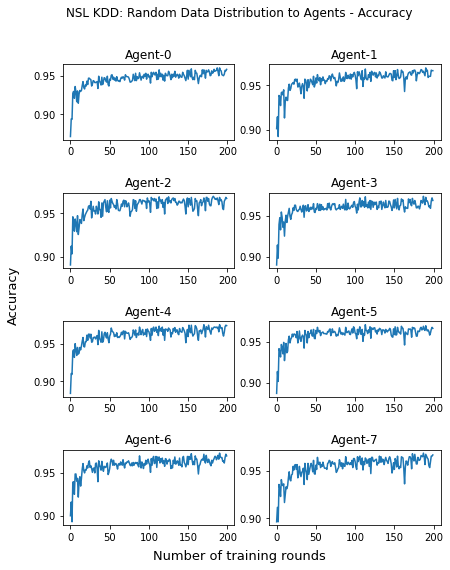

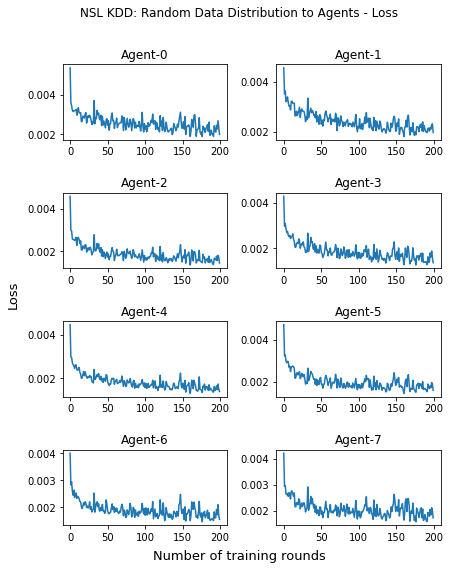

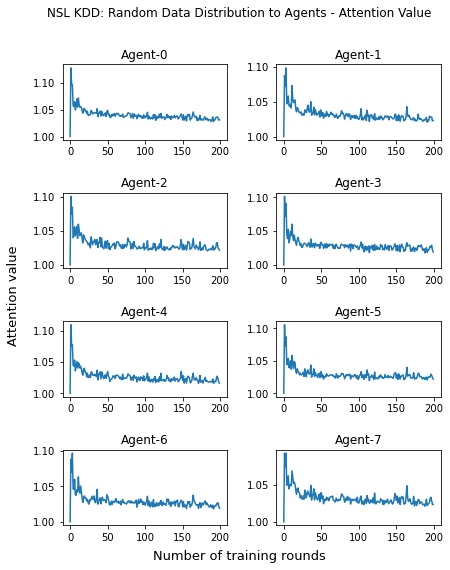

In [8]:
print_graphs_subplots('exp-1', 4, 2, 'NSL KDD: Random Data Distribution to Agents')

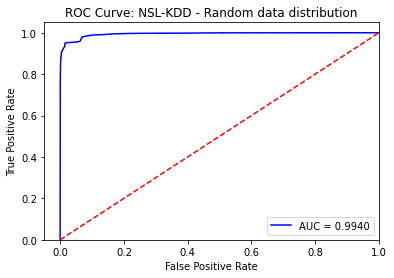

Accuracy : 0.9669368346682967
FPR      : 0.01954232933873866
Recall   : 0.95140712945591
Precision: 0.9769515035816243
F1-Score : 0.9640101272823111
ROC AUC  : 0.9939986660968986


In [9]:
weights_file = '../../results/exp-1/weights/round-' + str(args.agent_data_splits - 1)  + '-weights.npy'
net_1 = load_netowrk_weights(weights_file, args.nsl_columns)

# print_metrics(net_1, x, y)
print_metrics_with_roc(net_1, x, y, 'NSL-KDD', 'Random')

### Experiment - 2: NSL Customized Data Split

../../results/exp-2\client-0-metrics.npy
../../results/exp-2\client-1-metrics.npy
Number of agents: 2
Saving graphs for Accuracy...
Saving graphs for Loss...
Saving graphs for Attention values..


<ipython-input-3-c32b0dd7202c>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acc_fig.show()
<ipython-input-3-c32b0dd7202c>:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  loss_fig.show()
<ipython-input-3-c32b0dd7202c>:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  attn_fig.show()


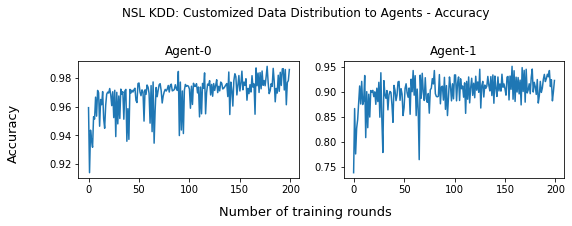

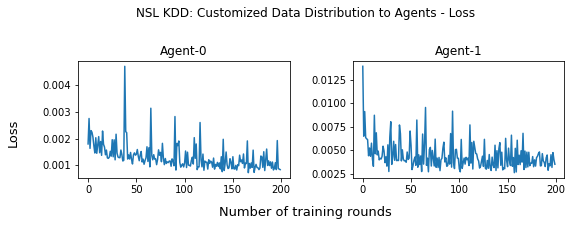

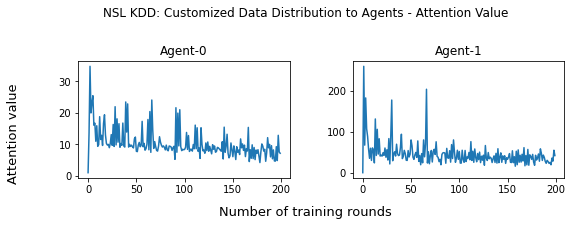

In [10]:
# print_graphs('exp-2')
print_graphs_subplots('exp-2', 1, 2, 'NSL KDD: Customized Data Distribution to Agents')

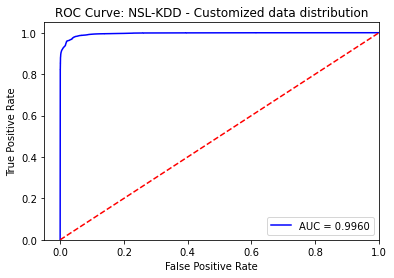

Accuracy : 0.9609672067380588
FPR      : 0.01057305356320815
Recall   : 0.9282790380351356
Precision: 0.9870867112828047
F1-Score : 0.9567800856135787
ROC AUC  : 0.9960260670042629


In [11]:
weights_file = '../../results/exp-2/weights/round-' + str(args.agent_data_splits - 1)  + '-weights.npy'
net_2 = load_netowrk_weights(weights_file, args.nsl_columns)

# print_metrics(net_2, x, y)
print_metrics_with_roc(net_2, x, y, 'NSL-KDD', 'Customized')

# ISOT CID Dataset

In [12]:
isot_files = glob.glob('../../data/isot/day_wise_normalized/*.csv')
days = []

for file in isot_files:
    df = pd.read_csv(file)
    days.append(df)
    
isot_df = pd.concat(days)
x = isot_df.drop('class', axis=1)
y = isot_df['class']

### Experiment - 3: ISOT Random Data Split

../../results/exp-3\client-0-metrics.npy
../../results/exp-3\client-1-metrics.npy
../../results/exp-3\client-2-metrics.npy
../../results/exp-3\client-3-metrics.npy
../../results/exp-3\client-4-metrics.npy
../../results/exp-3\client-5-metrics.npy
../../results/exp-3\client-6-metrics.npy
../../results/exp-3\client-7-metrics.npy
Number of agents: 8
Saving graphs for Accuracy...
Saving graphs for Loss...
Saving graphs for Attention values..


<ipython-input-3-c32b0dd7202c>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acc_fig.show()
<ipython-input-3-c32b0dd7202c>:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  loss_fig.show()
<ipython-input-3-c32b0dd7202c>:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  attn_fig.show()


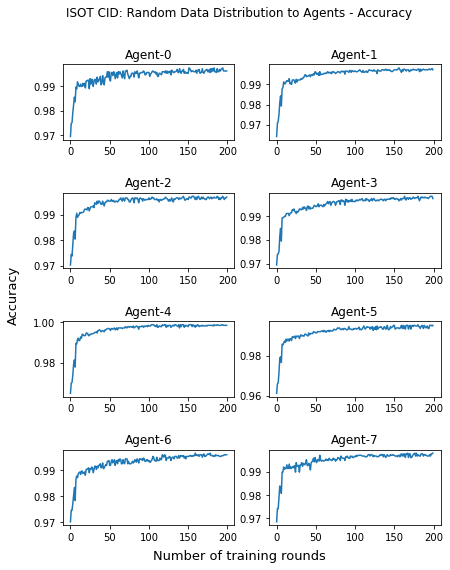

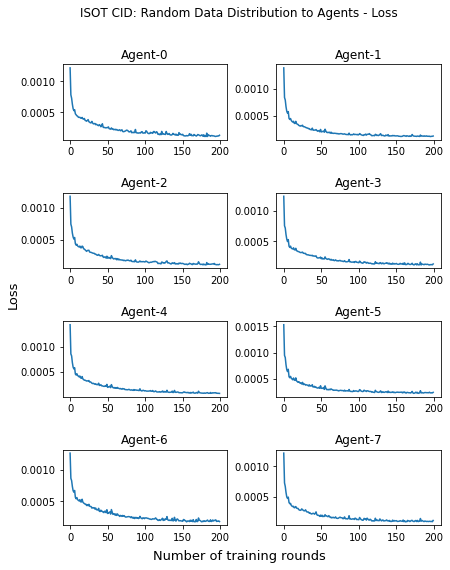

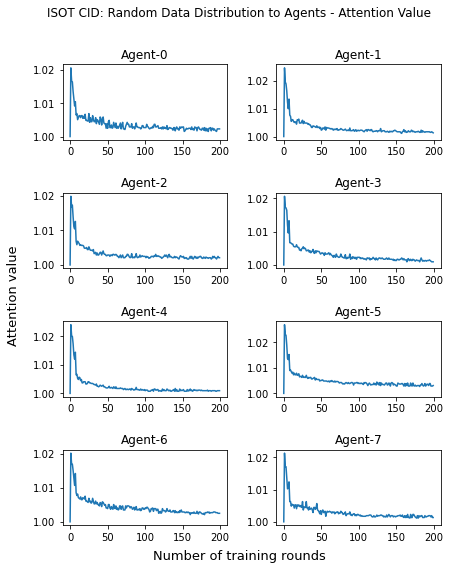

In [13]:
print_graphs_subplots('exp-3', 4, 2, 'ISOT CID: Random Data Distribution to Agents')

In [14]:
# print_graphs('exp-3')

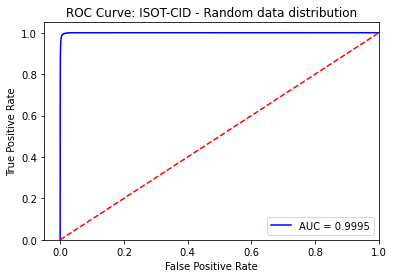

Accuracy : 0.9966747505080242
FPR      : 0.0017555738455986994
Recall   : 0.9468741960380757
Precision: 0.9444444444444444
F1-Score : 0.9456577595066805
ROC AUC  : 0.9995126276766102


In [15]:
weights_file = '../../results/exp-3/weights/round-' + str(args.agent_data_splits - 1)  + '-weights.npy'
net_3 = load_netowrk_weights(weights_file, args.isot_columns)

# print_metrics(net_3, x, y)
print_metrics_with_roc(net_3, x, y, 'ISOT-CID', 'Random')

### Experiment - 4: ISOT Customized Data Split

../../results/exp-4\client-0-metrics.npy
../../results/exp-4\client-1-metrics.npy
../../results/exp-4\client-2-metrics.npy
../../results/exp-4\client-3-metrics.npy
../../results/exp-4\client-4-metrics.npy
Number of agents: 5
Saving graphs for Accuracy...
Saving graphs for Loss...
Saving graphs for Attention values..


<ipython-input-3-c32b0dd7202c>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acc_fig.show()
<ipython-input-3-c32b0dd7202c>:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  loss_fig.show()
<ipython-input-3-c32b0dd7202c>:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  attn_fig.show()


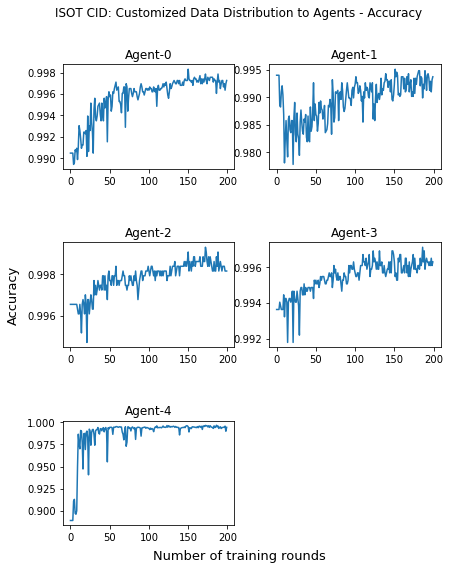

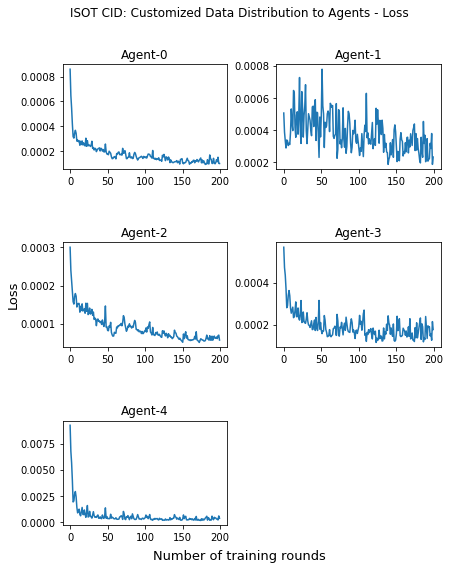

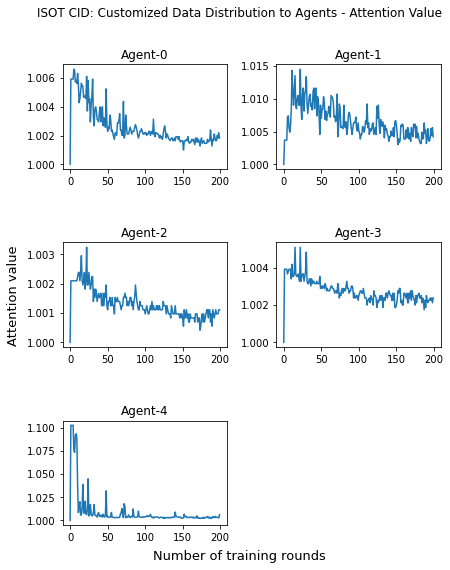

In [16]:
# print_graphs('exp-4')
print_graphs_subplots('exp-4', 3, 2, 'ISOT CID: Customized Data Distribution to Agents')

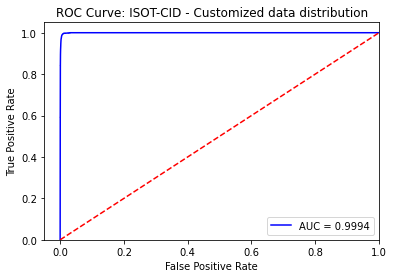

Accuracy : 0.9953776673728564
FPR      : 0.0008676508151457775
Recall   : 0.8762541806020067
Precision: 0.9695417022487902
F1-Score : 0.9205405405405406
ROC AUC  : 0.9993900423155869


In [17]:
weights_file = '../../results/exp-4/weights/round-' + str(args.agent_data_splits - 1)  + '-weights.npy'
net_4 = load_netowrk_weights(weights_file, args.isot_columns)

# print_metrics(net_4, x, y)
print_metrics_with_roc(net_4, x, y, 'ISOT-CID', 'Customized')